# Avaliação 03 - Implementação de Filtros Digitais

---

### Projeto 2: Butterworth por Transformação Bilinear



> Projete, a partir de um filtro passa-baixas Butterworth de sexta ordem, um filtro discreto passa-baixas com frequência de corte (-3dB) igual ωc = 2π/3, usando o método de transformação bilinear. Faça a implementação sob forma direta e sob forma em cascata. Represente os coeficientes em ponto flutuante (ex.: 0, 00423578 = 0, 423578 × 10-2) e vá diminuindo o número de casas decimais após a vírgula nas formas direta e em cascata para verificar a sensibilidade a quantização de parâmetros. Trace a curva do módulo da resposta em frequência em dB para os casos de precisão infinita e precisão finita. Em seguida, para a representação em forma direta, refaça os filtros com as 3 transformações em frequência a seguir (Z^-1 = -z^-1; Z^-1 = z^-2 e Z^-1 = -z^-2) e trace a curva do módulo em dB da resposta em frequência resultante. Use os seus filtros para processar um sinal de áudio de sua preferência, ouça os resultados e os avalie perceptualmente. Avalie, também, o espectro em função do tempo, do sinal de entrada e de saída utilizando um espectrograma.



ENGC63 - 2023.1

Mauricio dos Santos de Jesus e Yago Martins

## Imports

In [26]:
import math
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from scipy.fft import fft, fftfreq
from scipy.io.wavfile import read, write
from IPython.display import display, Math, Audio
import librosa
from google.colab import files


## Funções Auxiliares

In [27]:
# Imprime float em notação científica
def print_scientific(number):
    exp = np.floor(np.log10(np.abs(number))).astype(int)
    num = number * 10.0**(-exp - 1)
    display(Math(r"{0} \times 10^{{{1}}}".format(num, exp+1)))

# Reduz precisão da mantissa de um float
def reduce_precision(num, precision):
    exp = np.floor(np.log10(np.abs(num))).astype(int)
    num = np.around(num, exp+precision)
    return num

## Filtro Digital Discreto Passa-Baixas

Transformação Bilinear de um filtro Butterworth

### Filtro Butterworth

Calculamos os coeficientes de um filtro Butterworth analógico de ordem 6, com uma frequência de corte especificada. Ele gera tanto a representação em coeficientes de numerador e denominador quanto a representação em zeros-polos-ganho para uso em cascata com outros filtros.

In [28]:
order = 6          # Ordem do Butterworth
fs = 44100         # Freq de amostragem para audio de 20kHz
wc = 2*np.pi/3     # Freq de corte em rad/amostras (cutoff)

fc = fs*wc/(2*np.pi) # Freq de corte em Hz
Wc = 2*np.pi*fc      # Freq angular de corte [rad/s]

# Cria filtro Butterworth:
butt_zpk = signal.butter(order, Wc, btype='lowpass', analog=True, output='zpk') # Gera zpk para uso em cascata
butt_tf = signal.zpk2tf(*butt_zpk) # Converte zpk para tf (b/a)

filts = signal.lti(*butt_tf)      # Filtro analógico
filts_zpk = signal.lti(*butt_zpk) # Versão zpk para uso em cascata


### Transformação Bilinear

Realizamos a conversão do filtro Butterworth analógico para um filtro digital. São gerados os coeficientes do filtro digital, bem como uma representação em forma de Seção de Segunda Ordem (SOS) para uso em cascata. A resposta em frequência tanto do filtro digital quanto do filtro analógico é calculada para fins de plotagem e análise.


In [29]:
# Converte Butterworth para filtro digital por Transformação Linear:
filtz = signal.dlti(*signal.bilinear(filts.num, filts.den, fs=fs)) # Filtro digital
filtz_zpk = signal.dlti(*signal.bilinear_zpk(filts_zpk.zeros,
                                             filts_zpk.poles,
                                             filts_zpk.gain, fs=fs)) # Versão zpk para uso em cascata

z = filtz_zpk.zeros.copy()
p = filtz_zpk.poles.copy()
k = filtz_zpk.gain.copy()

sos = signal.zpk2sos(z, p, k)  # Converte zpk para sistemas de segunda ordem (cascata)

# Gera parâmetros para plotagem dos filtros
wz, hz = signal.freqz(filtz.num, filtz.den)              # Digital
ws, hs = signal.freqs(filts.num, filts.den, worN=fs*wz)  # Analógico

### Respostas em frequência

As diferenças nos gráficos entre o filtro Butterworth analógico e o filtro resultante da transformação bilinear podem ser atribuídas à distorção de warping

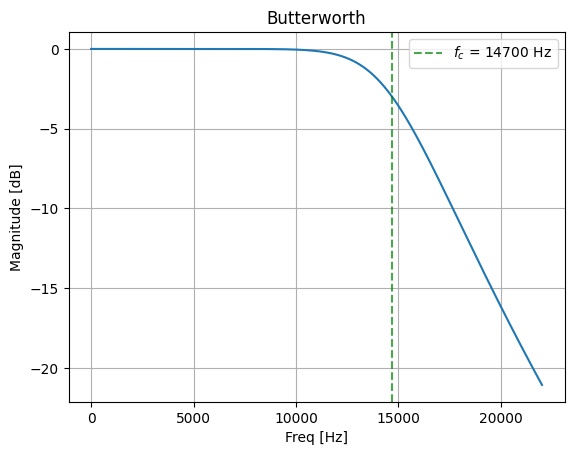

In [30]:
plt.plot(wz*fs/(2*np.pi), 20*np.log10(np.abs(hs)))
plt.axvline(x=fc, color='green', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
ax = plt.axis()
plt.legend()
plt.title('Butterworth')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

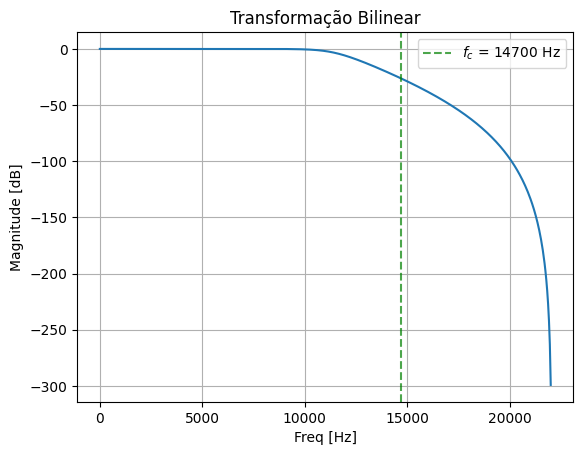

In [31]:
plt.plot(wz*fs/(2*np.pi), 20*np.log10(np.abs(hz)))
plt.axvline(x=fc, color='green', ls='--', label='$f_c$ = {} Hz'.format(round(fc)), alpha=0.7)
plt.legend()
plt.title('Transformação Bilinear')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()
plt.show()

## Função para Forma Direta I

 implementamos a saída de um filtro digital usando a forma direta I. Ele calcula a saída do filtro iterativamente para cada amostra do sinal de entrada, levando em consideração os coeficientes de numerador e denominador do filtro.


In [32]:
# Encontra saída pela Forma Direta I
def direct_i(input_x, filtz):
    x = input_x.copy()
    input_size = len(x)

    b = filtz.num.copy()
    a = filtz.den.copy()

    M = len(b) - 1
    N = len(a) - 1

    y = np.zeros(input_size)

    # Função para retornar 0 em caso de índice inválido
    def get_value(array, index):
        try:
            return array[index]
        except:
            return 0

    # Percorre por toda entrada
    for n in range(input_size):
        # Somatórios resultantes da Forma Direta I
        for i in range(M+1):
            y[n] += b[i] * get_value(x, n - i)
        for j in range(1, N+1):
            y[n] -= a[j] * get_value(y, n - j)

    return y

## Função para Forma em Cascata
Implementamos a saída de um filtro digital usando a forma em cascata. A filtragem do sinal de entrada é realizada pela função signal.sosfilt(), que aplica sequencialmente os sistemas representados pelas seções de segunda ordem. A saída filtrada é retornada pela função. A forma em cascata é uma forma eficiente de implementar filtros digitais complexos dividindo-os em seções de segunda ordem independentes.


In [33]:
# Encontra saída pela Forma em Cascata
def cascade(input_x, sos):  # Recebe parâmetros em forma de Sistemas de Segunda Ordem

    y = signal.sosfilt(sos, x)  # Filtra entrada através da sequência em cascata dos sistemas

    return y

## Reduz Casas Decimais para Forma Direta (TF)

 Reduzimos a precisão dos parâmetros "b" e "a" do filtro original para diferentes níveis de casas decimais. Isso é feito para avaliar o impacto da redução de precisão nos gráficos da resposta em frequência do filtro.

In [34]:
# Reduz parâmetros b e a da Função de Transferência para uso na Forma Direta

# Precisão infinita
wz1, hz1 = signal.freqz(filtz.num, filtz.den)

# Redução para 5 casas decimais
filtz_5prec = signal.dlti(filtz.num, filtz.den)

for i, val in enumerate(filtz_5prec.num):
    filtz_5prec.num[i] = reduce_precision(val, 5)
for i, val in enumerate(filtz_5prec.den):
    filtz_5prec.den[i] = reduce_precision(val, 5)

wz2, hz2 = signal.freqz(filtz_5prec.num, filtz_5prec.den)

# Redução para 3 casas decimais
filtz_3prec = signal.dlti(filtz.num, filtz.den)

for i, val in enumerate(filtz_3prec.num):
    filtz_3prec.num[i] = reduce_precision(val, 3)
for i, val in enumerate(filtz_3prec.den):
    filtz_3prec.den[i] = reduce_precision(val, 3)

wz3, hz3 = signal.freqz(filtz_3prec.num, filtz_3prec.den)

## Reduz Casas Decimais para Forma Cascata (SOS)

Aqui fazemos os mesmo para Forma direta, reduzimos a precisão dos parâmetros SOS do filtro original para diferentes níveis de casas decimais. Isso é feito para avaliar o impacto da redução de precisão nos gráficos da resposta em frequência do filtro na forma em cascata.

In [35]:
# Reduz parâmetros SOS para uso na Forma em Cascata

# Precisão infinita
cwz1, chz1 = signal.sosfreqz(sos)

# Redução para 5 casas decimais
sos_5 = sos.copy()

for i, row in enumerate(sos_5):
    for j, val in enumerate(row):
        sos_5[i][j] = reduce_precision(val, 5)

cwz2, chz2 = signal.sosfreqz(sos_5)

# Redução para 3 casas decimais
sos_3 = sos.copy()

for i, row in enumerate(sos_3):
    for j, val in enumerate(row):
        sos_3[i][j] = reduce_precision(val, 3)

cwz3, chz3 = signal.sosfreqz(sos_3)

In [36]:
print(sos_3)

[[0.   0.1  0.   1.   0.   0.  ]
 [1.   2.   1.   1.   0.1  0.17]
 [1.   2.   1.   1.   0.1  0.59]]


## Transformação $Z^{-1} = -z^{-1}$

In [37]:
def first_transf_tf(b, a):
    b1 = b.copy()
    a1 = a.copy()
    for idx, val in enumerate(b1):
        if idx % 2 == b1.shape[0] % 2:
            b1[idx] = -val
    for idx, val in enumerate(a1):
        if idx % 2 == a1.shape[0] % 2:
            a1[idx] = -val
    return b1, a1


filtz_ft = signal.dlti(*first_transf_tf(filtz.num, filtz.den))

## Transformação $Z^{-1} = z^{-2}$

In [38]:
def second_transf_tf(b, a):
    newList = []
    for idx, val in enumerate(b):
        newList.append(val)
        newList.append(0)
    b1 = np.array(newList[:-1])
    newList = []
    for idx, val in enumerate(a):
        newList.append(val)
        newList.append(0)
    a1 = np.array(newList[:-1])

    return b1, a1


filtz_st =  signal.dlti(*second_transf_tf(filtz.num, filtz.den))

## Transformação $Z^{-1} = -z^{-2}$

In [39]:
def third_transf_tf(b, a):
    b_1, a_1 = first_transf_tf(b, a)
    b_2, a_2 = second_transf_tf(b_1, a_1)
    return b_2, a_2

filtz_tt = signal.dlti(*third_transf_tf(filtz.num, filtz.den))

## Carrega áudio de entrada

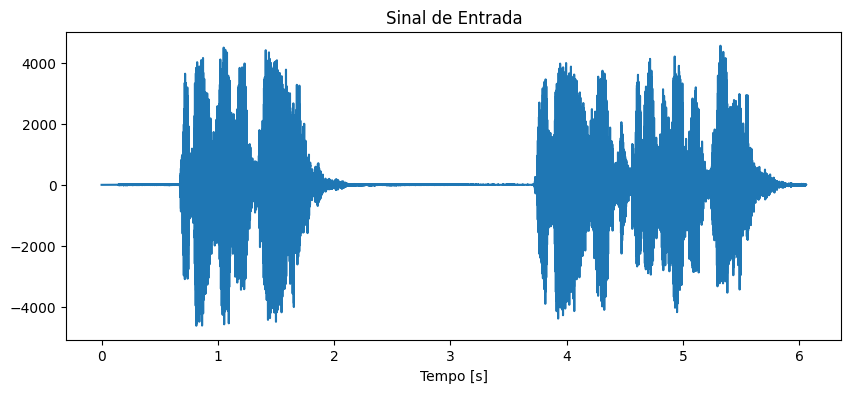

/usr/local/lib/python3.10/dist-packages/matplotlib/axes/_axes.py:7773: RuntimeWarning: divide by zero encountered in log10
  Z = 10. * np.log10(spec)


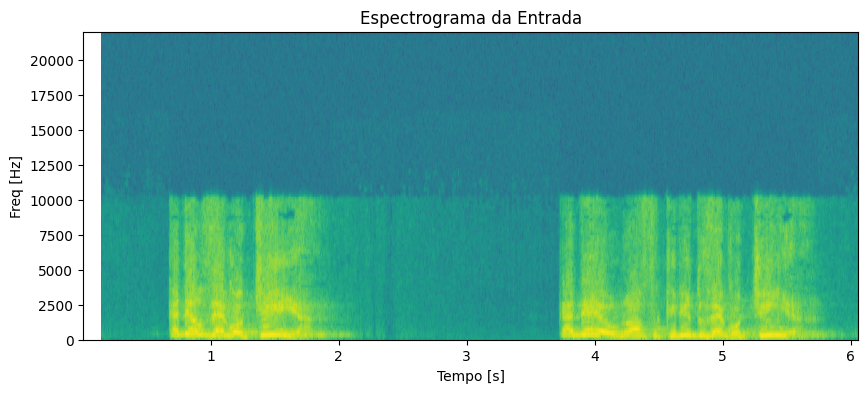

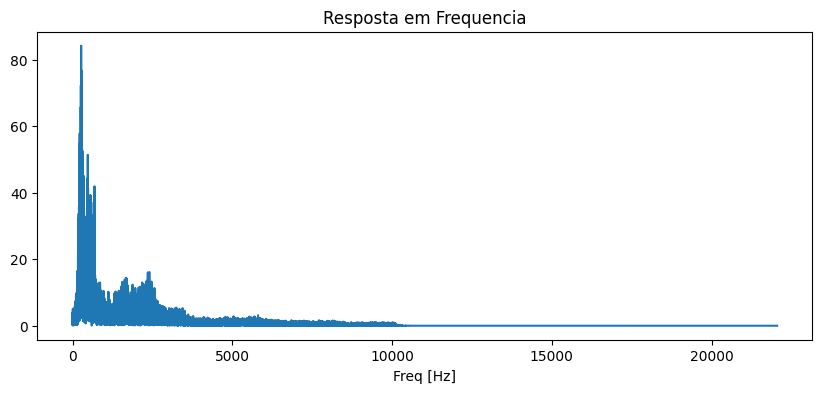

In [40]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import wavfile
from scipy.fft import fft, fftfreq
from IPython.display import Audio

(freq, x) = wavfile.read("/content/cade-o-ze-gotinha.wav")
N = x.shape[0]
t = np.linspace(0, N/freq, N)

xf = fft(x)
f = fftfreq(N, 1/freq)[:N//2]

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(t, x)
plt.title("Sinal de Entrada")
plt.xlabel("Tempo [s]")
plt.show()

plt.figure(figsize=(10, 4), dpi=100)
plt.specgram(x, Fs=freq, sides='onesided')
plt.title('Espectrograma da Entrada')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.figure(figsize=(10, 4), dpi=100)
plt.plot(f, 2.0/N * np.abs(xf[0:N//2]))
plt.title("Resposta em Frequencia")
plt.xlabel("Freq [Hz]")
plt.show()

Audio("/content/cade-o-ze-gotinha.wav")


## Filtragem

### Direto com precisão infinita

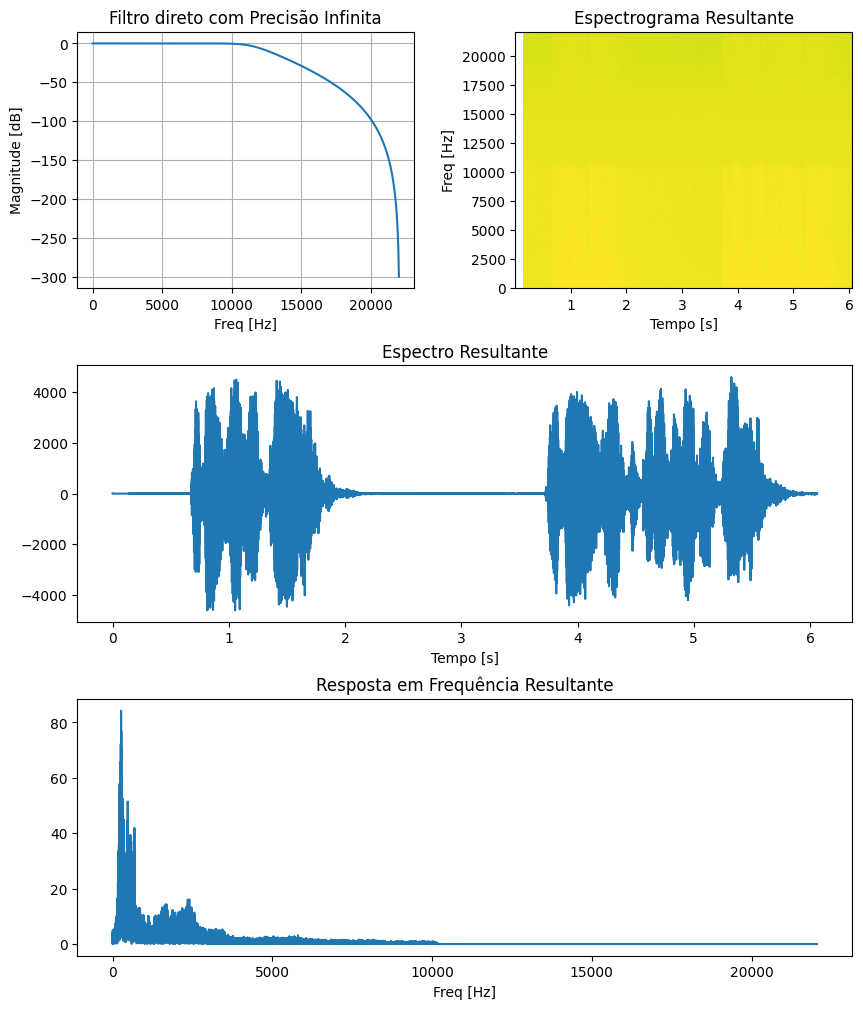

TransferFunctionDiscrete(
array([0.03391037, 0.20346223, 0.50865558, 0.67820744, 0.50865558,
       0.20346223, 0.03391037]),
array([1.        , 0.17415911, 0.78901525, 0.08259211, 0.11713691,
       0.00554934, 0.0018111 ]),
dt: True
)


In [41]:
direct_infi = direct_i(x, filtz)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(wz1*fs/(2*np.pi), 20*np.log10(np.abs(hz1)), label=r'$|H_z(e^{j \omega})|$')
ax = plt.axis()
plt.title('Filtro direto com Precisão Infinita')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(direct_infi, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.subplot(3, 2, (3, 4))
plt.plot(t, direct_infi)
plt.title("Espectro Resultante")
plt.xlabel("Tempo [s]")

plt.subplot(3, 2, (5, 6))
plt.plot(f, 2.0/N * np.abs(fft(direct_infi)[0:N//2]))
plt.title("Resposta em Frequência Resultante")
plt.xlabel("Freq [Hz]")

plt.show()

print(filtz)

Audio(direct_infi, rate=freq)

### Direto com precisão de 5 casas decimais

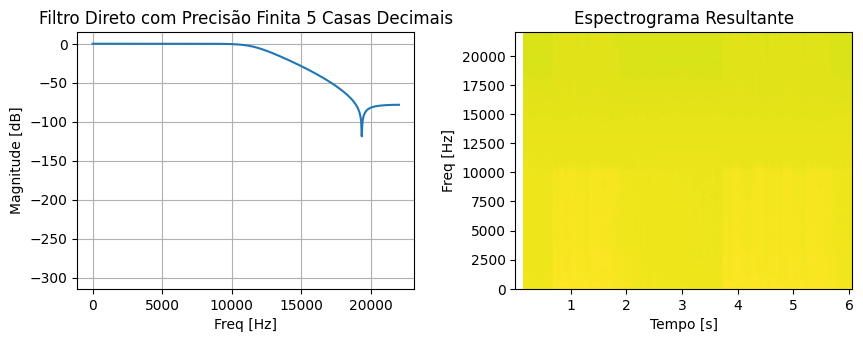

TransferFunctionDiscrete(
array([0.034 , 0.2035, 0.5087, 0.6782, 0.5087, 0.2035, 0.034 ]),
array([1.    , 0.1742, 0.789 , 0.083 , 0.1171, 0.01  , 0.    ]),
dt: True
)


In [42]:
direct_5 = direct_i(x, filtz_5prec)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(wz2*fs/(2*np.pi), 20*np.log10(np.abs(hz2)), label=r'$|H_z(e^{j \omega})|$')
plt.axis((ax))
plt.title('Filtro Direto com Precisão Finita 5 Casas Decimais')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(direct_5, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.show()

print(filtz_5prec)

Audio(direct_5, rate=freq)

### Direto com precisão de 3 casas decimais

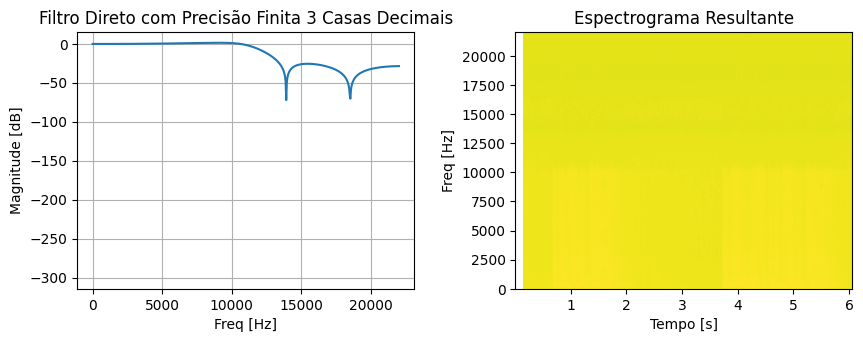

TransferFunctionDiscrete(
array([0.  , 0.2 , 0.51, 0.68, 0.51, 0.2 , 0.  ]),
array([1.  , 0.17, 0.79, 0.1 , 0.12, 0.  , 0.  ]),
dt: True
)


In [43]:
direct_3 = direct_i(x, filtz_3prec)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(wz3*fs/(2*np.pi), 20*np.log10(np.abs(hz3)), label=r'$|H_z(e^{j \omega})|$')
plt.axis(ax)
plt.title('Filtro Direto com Precisão Finita 3 Casas Decimais')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(direct_3, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.show()

print(filtz_3prec)

Audio(direct_3, rate=freq)

### Cascata com precisão infinita

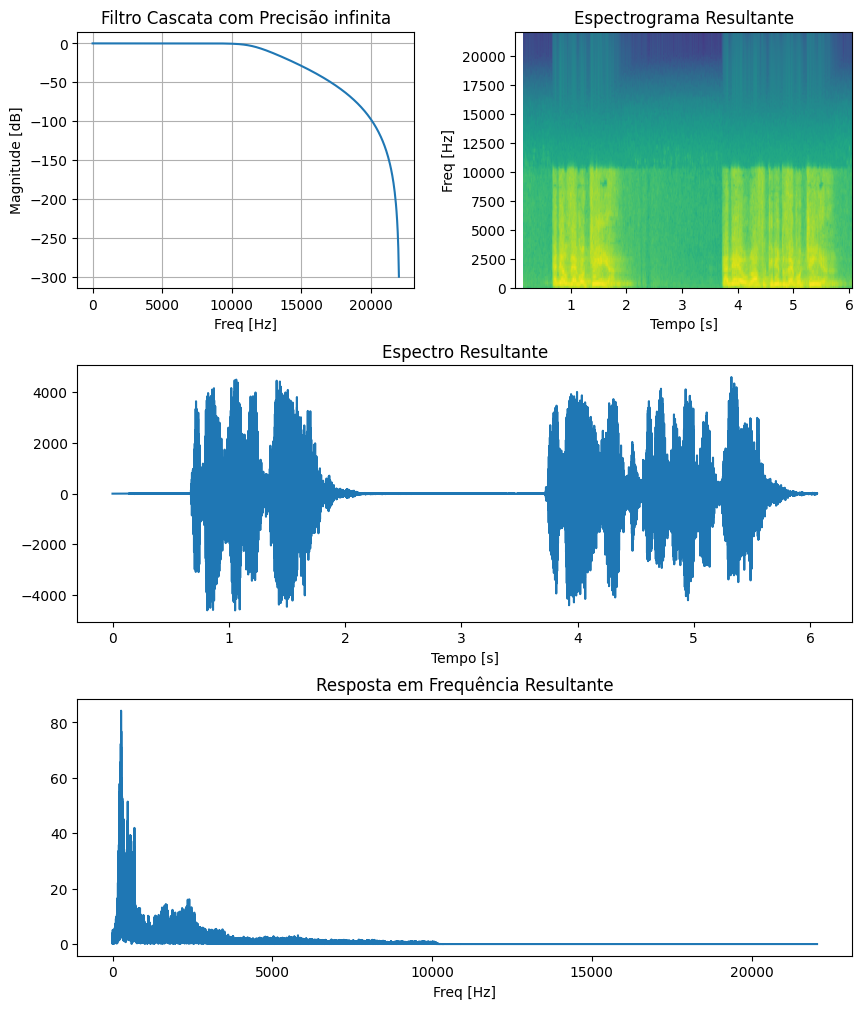

[[0.03391037 0.06782074 0.03391037 1.         0.04690818 0.01786374]
 [1.         2.         1.         1.         0.05401563 0.1720887 ]
 [1.         2.         1.         1.         0.07323531 0.58913785]]


In [44]:
cascade_infi = cascade(x, sos)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(cwz1*fs/(2*np.pi), 20*np.log10(np.abs(chz1)), label=r'$|H_z(e^{j \omega})|$')
ax = plt.axis()
plt.title('Filtro Cascata com Precisão infinita')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(cascade_infi, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.subplot(3, 2, (3, 4))
plt.plot(t, cascade_infi)
plt.title("Espectro Resultante")
plt.xlabel("Tempo [s]")

plt.subplot(3, 2, (5, 6))
plt.plot(f, 2.0/N * np.abs(fft(cascade_infi)[0:N//2]))
plt.title("Resposta em Frequência Resultante")
plt.xlabel('Freq [Hz]')

plt.show()

print(sos)

Audio(cascade_infi, rate=freq)

### Cascata com precisão de 5 casas decimais

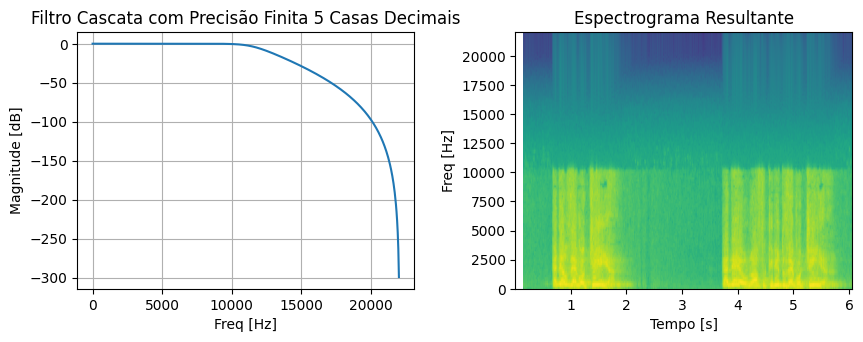

[[0.034  0.068  0.034  1.     0.047  0.018 ]
 [1.     2.     1.     1.     0.054  0.1721]
 [1.     2.     1.     1.     0.073  0.5891]]


In [45]:
cascade_5 = cascade(x, sos_5)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(cwz2*fs/(2*np.pi), 20*np.log10(np.abs(chz2)), label=r'$|H_z(e^{j \omega})|$')
plt.axis((ax))
plt.title('Filtro Cascata com Precisão Finita 5 Casas Decimais')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(cascade_5, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.show()

print(sos_5)

Audio(cascade_5, rate=freq)

### Cascata com precisão de 3 casas decimais

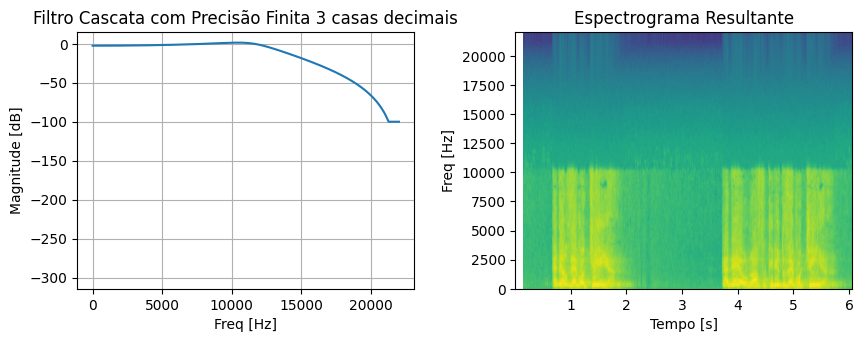

[[0.   0.1  0.   1.   0.   0.  ]
 [1.   2.   1.   1.   0.1  0.17]
 [1.   2.   1.   1.   0.1  0.59]]


In [46]:
cascade_3 = cascade(x, sos_3)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(cwz3*fs/(2*np.pi), 20*np.log10(np.maximum(np.abs(chz3), 1e-5)), label=r'$|H_z(e^{j \omega})|$')
plt.axis((ax))
plt.title('Filtro Cascata com Precisão Finita 3 casas decimais')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(cascade_3, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.show()

print(sos_3)

Audio(cascade_3, rate=freq)

### Direto com Transformação $Z^{-1} = -z^{-1}$

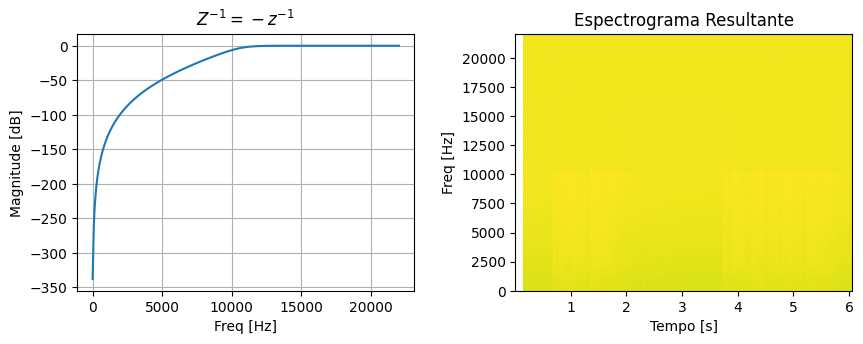

TransferFunctionDiscrete(
array([ 0.03391037, -0.20346223,  0.50865558, -0.67820744,  0.50865558,
       -0.20346223,  0.03391037]),
array([ 1.        , -0.17415911,  0.78901525, -0.08259211,  0.11713691,
       -0.00554934,  0.0018111 ]),
dt: True
)


In [47]:
trans1 = direct_i(x, filtz_ft)

wz, hz = signal.freqz(filtz_ft.num, filtz_ft.den)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(wz*fs/(2*np.pi), 20*np.log10(np.abs(hz)), label=r'$|H_z(e^{j \omega})|$')
plt.title(r'$ Z^{-1} = -z^{-1} $')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(trans1, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.show()

print(filtz_ft)

Audio(trans1, rate=freq)

### Direto com Transformação $Z^{-1} = z^{-2}$

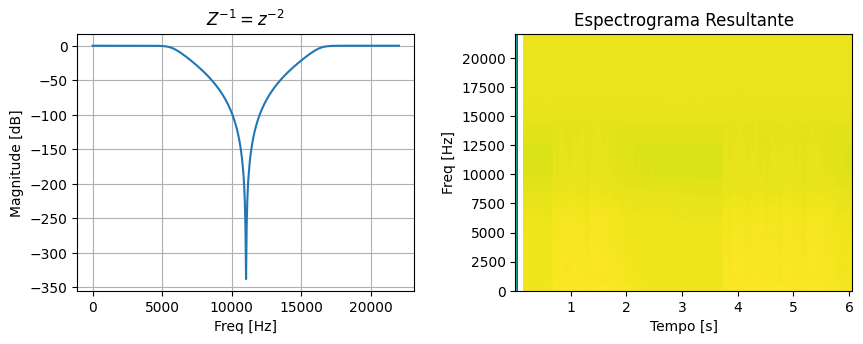

TransferFunctionDiscrete(
array([0.03391037, 0.        , 0.20346223, 0.        , 0.50865558,
       0.        , 0.67820744, 0.        , 0.50865558, 0.        ,
       0.20346223, 0.        , 0.03391037]),
array([1.        , 0.        , 0.17415911, 0.        , 0.78901525,
       0.        , 0.08259211, 0.        , 0.11713691, 0.        ,
       0.00554934, 0.        , 0.0018111 ]),
dt: True
)


In [48]:
trans2 = direct_i(x, filtz_st)

wz, hz = signal.freqz(filtz_st.num, filtz_st.den)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(wz*fs/(2*np.pi), 20*np.log10(np.abs(hz)), label=r'$|H_z(e^{j \omega})|$')
plt.title(r'$Z^{-1} = z^{-2}$')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(trans2, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.show()

print(filtz_st)

Audio(trans2, rate=freq)

### Direto com Transformação $Z^{-1} = -z^{-2}$

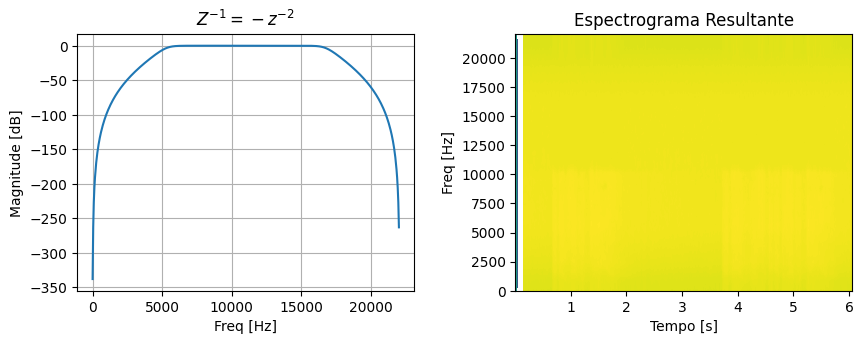

TransferFunctionDiscrete(
array([ 0.03391037,  0.        , -0.20346223,  0.        ,  0.50865558,
        0.        , -0.67820744,  0.        ,  0.50865558,  0.        ,
       -0.20346223,  0.        ,  0.03391037]),
array([ 1.        ,  0.        , -0.17415911,  0.        ,  0.78901525,
        0.        , -0.08259211,  0.        ,  0.11713691,  0.        ,
       -0.00554934,  0.        ,  0.0018111 ]),
dt: True
)


In [49]:
trans3 = direct_i(x, filtz_tt)

wz, hz = signal.freqz(filtz_tt.num, filtz_tt.den)

plt.figure(figsize=(10, 12), dpi=100)
plt.subplot(3, 2, 1)
plt.subplots_adjust(wspace=0.3, hspace=0.3)
plt.plot(wz*fs/(2*np.pi), 20*np.log10(np.abs(hz)), label=r'$|H_z(e^{j \omega})|$')
plt.title(r'$Z^{-1} = -z^{-2}$')
plt.xlabel('Freq [Hz]')
plt.ylabel('Magnitude [dB]')
plt.grid()

plt.subplot(3, 2, 2)
plt.specgram(trans3, Fs=fs, sides='onesided')
plt.title('Espectrograma Resultante')
plt.ylabel('Freq [Hz]')
plt.xlabel('Tempo [s]')

plt.show()

print(filtz_tt)

Audio(trans3, rate=freq)